## Final conclusion:


### CCG algorithm and baseline estimation
- bin size = 0.2 ms
- Optimal params for jittering methods:
  - shuffle iteration = 1000
  - alpha = 0.001
  - jitter windows = +/- 5ms
- Deconvolution helps removing second-order statistics (bursting) from CCG and improves connection strength. However, it doesn't always work. So, might be okay to skip it for now
- Optimal params for convolution methods:
  - 10 ms gaussian window with HF=0.6
  - 10 ms median filter window with HF=1
- **Convolution methods works similar, if not better than Jittering method overall**.
- Convolution is **computationally faster** than Jittering method

###  significance determination
- peak p-value < 0.001 and > 2.5 std above baseline
- dip p-value < 0.001 and > 1.5 std above baseline
- peak (or dip) 0.8 ms < width < 4 ms, all values p-value < 0.01, and > 1 std above baseline
- should be asymmetric, edges should not overlap with zero-lag bin. Some zero-lag connx still get through
- for each sig. connection, strength = sum of values above (or below) baseline in 0.8-5 ms range divided by number of reference spike
- for each sig. connection, strength measure 2 = ratio of peak (or drip) wrt to average(baseline) in 0.8-5 ms range

In [1]:
import tqdm, os
import numpy as np
from ccgutils import *
import scipy.io as spio
import pynapple as nap
import matplotlib.pyplot as plt

In [2]:
# general params
bin_dur = 0.0004 # 0.4 ms
win_dur = 0.05 # 50 ms
alpha = 0.001 # p-val for peak
deconvolve = False

# jitter params
jitterMax = 0.005 # 5 ms [+/- 5ms seconds] Schwindel et al. 
shufJitterIter = 1000 # shuffle 1000times

# convolution params
convType = 'median' # convolution type: gaussian or median
W = int(0.01/bin_dur) # 10 ms

# significance calculation
min_win_monosyn = 0.0008 # 0.8ms
win_monosyn = 0.0048 # right edge of window to look for mono-synaptic connection
alpha2 = 0.01 # p-val threshold for peak or dip width
# width should be above alpha2 in (0.8 - 4ms) range; 5-0.8 = 4.2ms
sig_width = [0.0008, 0.004]
sig_width_inh = [0.0012, 0.004]
# zero-bins range : (-0.4 to 0.4) ms
zero_bins = [-0.0006, 0.0006] #ms
# peaksd, widthsd
peaksd = 2.5
dipsd = 2
widthsd = 1
# threshold for atleast few spikes
spkTh = 25

In [3]:
### Load 6 CA1 simultaneously recorded units
dat = spio.loadmat('CA1_Data.mat')
dat = dat['CA1_Data'][0][0]

# process spike times
spktimes = np.ravel(dat[0])
cluid = np.ravel(dat[1])
spkfs = float(dat[2][0][0])
total_time = float(dat[3][0][0])
spktimes = spktimes/spkfs

## Compute and plot CCG for each in +/- 30 ms window

In [4]:
# compute N spikes for each unit
cluid_ = np.unique(cluid)
nCells = len(cluid_) 
Nspk = np.zeros_like(cluid_, dtype='int')
# Loop through each unique value in Gsub and count occurrences in spkL
for c,cid in enumerate(cluid_):
    Nspk[c] = np.sum(cluid==cid)

# compute CCG
cch, t = CCG(spktimes, cluid, binSize=bin_dur, duration=win_dur, alpha=alpha)

# reshape and calculate auto-correlogram
if deconvolve:
    cch, ach1, nspks1, ach2, nspks2 = CCH3D_reshape(cch, Nspk)
    # deconvoluted cross-correlogram
    cch = cchdeconv(cch, ach1, nspks1, ach2, nspks2)
    # reshape for easier plotting
    cch = np.reshape(cch, [cch.shape[0],nCells,nCells])
cch = np.reshape(cch, [cch.shape[0],nCells,nCells])

# unique pairs (so we can work in both forward and backward direction)
cc_pairs = np.tril_indices(cch.shape[1], k=-1)
cc_pairs = np.column_stack(cc_pairs)

In [5]:
## create artifical data
# create artificial reciprocal E-I connection
#cch[63:76,3,5] = cch[63:76,3,5]-100
cch[50:63,3,5] = cch[50:63,3,5]-300

# create artificial reciprocal E-E connection
cch[50:63,2,5] = np.flipud(cch[63:76,2,5])

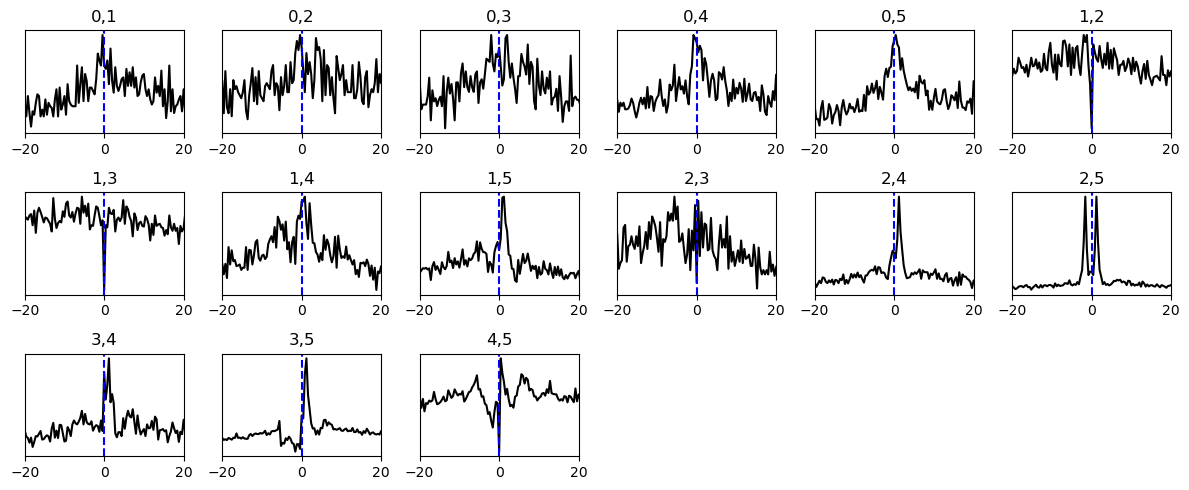

In [6]:
# plot CCG with significance bounds
count = 1 
plt.figure(figsize=(12,5))
for refcid in range(nCells):
    for targetcid in range(refcid+1,nCells):
        plt.subplot(3,6,count)
        plt.plot(t*1000, cch[:,refcid,targetcid], c='k')
        plt.axvline(x=0, c='b',ls='--')
        plt.xlim([-20,20])
        plt.yticks([])
        plt.title(str(refcid)+','+str(targetcid))
        count = count+1
plt.tight_layout()
plt.show()

## Jitter analysis

Calculate null distribution in +/- 5 ms jitter window and alpha=0.001

In [7]:
# calculate 1000 times jittered data
cc_null_dist = np.array(run_jittered_ccg(spktimes, cluid, Nspk, jitter_ms=int(jitterMax*1000), binwidth=bin_dur, windowsize=win_dur, num_jitters=shufJitterIter))
cc_null_dist = cc_null_dist.transpose(1, 2, 0) 
# null distribution for alpha = 0.001 for +/-5 ms jitter
null_ci_alpha = np.percentile(cc_null_dist,q=[alpha,50,100-alpha],axis=2)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.59it/s]


## Convolution and significance

In [8]:
# o/p variables 
Pval = np.full([len(t), nCells, nCells], np.nan)
Pred = np.full([len(t), nCells, nCells], np.nan)
Bounds = np.full([cch.shape[0], nCells, nCells, 2], np.nan)
Pcausal_exc = np.zeros([nCells, nCells])
Pcausal_inh = np.zeros([nCells, nCells])
syn_strength_exc = np.full([nCells, nCells], np.nan)
syn_ratio_exc = np.full([nCells, nCells], np.nan)
syn_strength_inh = np.full((nCells, nCells), np.nan)
syn_ratio_inh = np.full((nCells, nCells), np.nan)
sig_con_exc = []
sig_con_inh = []

# post and pre bins to mess with
# some sig. digit shit to deal with
postbins = (t>=min_win_monosyn) & (t<=win_monosyn+bin_dur/2)
prebins = (t<=-min_win_monosyn) & (t>=-win_monosyn-bin_dur/2)
zero_lag_bins = (t>=zero_bins[0]-bin_dur/2) & (t<=zero_bins[1]+bin_dur/2)

# go through each pair 
for refcid in range(nCells):
    for targetcid in range(refcid+1, nCells):
        # ccg for respective connection
        ccg = cch[:, refcid, targetcid]

        # calculate null-distribution using convolution based 
        # on Stark & Abeles; poisson continuity correction
        pvals, pred, qvals = cch_conv(ccg, W, WINTYPE=convType)
        pvals, pred, qvals = np.ravel(pvals), np.ravel(pred), np.ravel(qvals)
        # Store predicted values and pvalues for subsequent plotting
        Pred[:, refcid, targetcid] = pred
        Pval[:, refcid, targetcid] = pvals
        Pred[:, targetcid, refcid] = np.flipud(pred)
        Pval[:, targetcid, refcid] = np.flipud(pvals)
        
        # calculate upper and lower bound with bonferroni correction, given alpha levels
        hiBound, loBound = calculate_bounds(pred, alpha, np.ceil(win_monosyn/bin_dur)*2)
        Bounds[:, refcid, targetcid, 0] = hiBound
        Bounds[:, refcid, targetcid, 1] = loBound
        Bounds[:, targetcid, refcid, 0] = np.flipud(hiBound)
        Bounds[:, targetcid, refcid, 1] = np.flipud(loBound)

        # get baseline ccg and std
        baseline_ccg = ccg - pred
        std_baseline = np.nanstd(baseline_ccg)

        ########## EXCITATORY checks for both sides ref -> target (post), target -> ref (pre)
        sig = ccg > hiBound
        
        # check all condition
        # peak pval < 0.001, peak > 2.5 sd, in [0.8 - 4.8]ms
        # width pval < 0.01, width > 1 sd or 1/2*height of peak
        # no zero lag peaks (common input)
        post_exc_check, pre_exc_check = check_exc_conn(ccg, hiBound, loBound, pred, pvals, postbins, prebins, zero_lag_bins, bin_dur=bin_dur,
                                                       alpha=alpha, alpha2=alpha2, sig_width=sig_width, peaksd=peaksd, widthsd=widthsd)
        
        # store o/p
        if post_exc_check:
            # sum of values above baseline in postbins
            bccg = baseline_ccg[postbins]
            bccg[bccg<0] = 0
            syn_strength_exc[refcid,targetcid] = np.nansum(bccg)/Nspk[refcid]
            # peak/baseline ratio
            syn_ratio_exc[refcid, targetcid] = np.nanmax(ccg[postbins])/np.nanmean(pred[postbins])
            sig_con_exc.append([refcid, targetcid])
            Pcausal_exc[refcid, targetcid] = 1

        if pre_exc_check:
            # sum of values above baseline in postbins
            bccg = baseline_ccg[prebins]
            bccg[bccg<0] = 0
            syn_strength_exc[targetcid, refcid] = np.nansum(bccg)/Nspk[targetcid]
            # peak/baseline ratio
            syn_ratio_exc[targetcid, refcid] = np.nanmax(ccg[prebins])/np.nanmean(pred[prebins])
            sig_con_exc.append([targetcid, refcid])
            Pcausal_exc[targetcid, refcid] = 1

        #print(refcid, targetcid, post_exc_check, pre_exc_check)

        ######### INHIBITORY connections checks again for both directions
        post_inh_check, pre_inh_check = check_inh_conn(ccg, hiBound, loBound, pred, qvals, postbins, prebins, zero_lag_bins, bin_dur=bin_dur, 
                                                       alpha=alpha, alpha2=alpha2, sig_width=sig_width_inh, dipsd=dipsd, widthsd=widthsd)
        # remove if excitatory connections detected
        #if post_exc_check:
        #    post_inh_check = False
        #if pre_exc_check:
        #    pre_inh_check = False

        # store o/p
        if post_inh_check:
            # sum of values above baseline in postbins
            bccg = baseline_ccg[postbins]
            bccg[bccg>0] = 0
            syn_strength_inh[refcid,targetcid] = np.abs(np.nansum(bccg))/Nspk[refcid]
            # valley/baseline ratio
            syn_ratio_inh[refcid, targetcid] = np.abs(np.nanmin(ccg[postbins])/np.nanmean(pred[postbins]))
            sig_con_inh.append([refcid, targetcid])
            Pcausal_inh[refcid, targetcid] = -1

        if pre_inh_check:
            # sum of values above baseline in postbins
            bccg = baseline_ccg[prebins]
            bccg[bccg>0] = 0
            syn_strength_inh[targetcid, refcid] = np.abs(np.nansum(bccg)/Nspk[targetcid])
            # valley/baseline ratio
            syn_ratio_inh[targetcid, refcid] = np.abs(np.nanmin(ccg[prebins])/np.nanmean(pred[prebins]))
            sig_con_inh.append([targetcid, refcid])
            Pcausal_inh[targetcid, refcid] = -1
        
        #print(refcid, targetcid, post_inh_check, pre_inh_check)

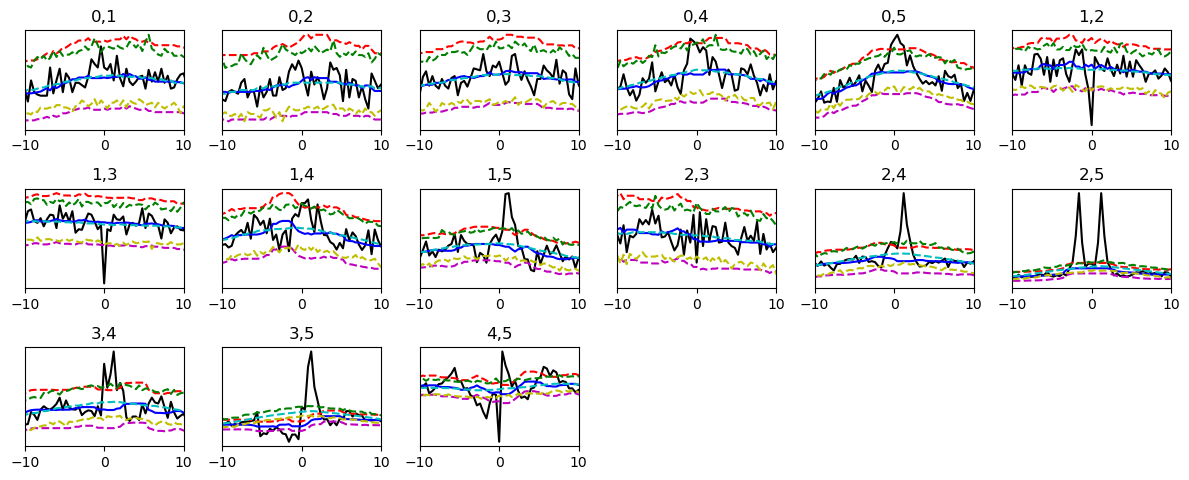

In [9]:
# plot CCG with significance bounds
count = 1 
plt.figure(figsize=(12,30))
for refcid in range(nCells):
    for targetcid in range(refcid+1,nCells):
        plt.subplot(19,6,count)
        plt.plot(t*1000, cch[:, refcid, targetcid], c='k')
        plt.plot(t*1000, Pred[:, refcid, targetcid], c='b')
        plt.plot(t*1000, Bounds[:,refcid,targetcid,0], 'r--')
        plt.plot(t*1000, Bounds[:,refcid,targetcid,1], 'm--')
        plt.plot(t*1000, null_ci_alpha[0,:,targetcid*nCells+refcid], 'y--')
        plt.plot(t*1000, null_ci_alpha[1,:,targetcid*nCells+refcid], 'c--')
        plt.plot(t*1000, null_ci_alpha[2,:,targetcid*nCells+refcid], 'g--')
        plt.xlim([-10,10])
        plt.yticks([])
        plt.title(str(refcid)+','+str(targetcid))
        count = count+1
plt.tight_layout()
plt.show()

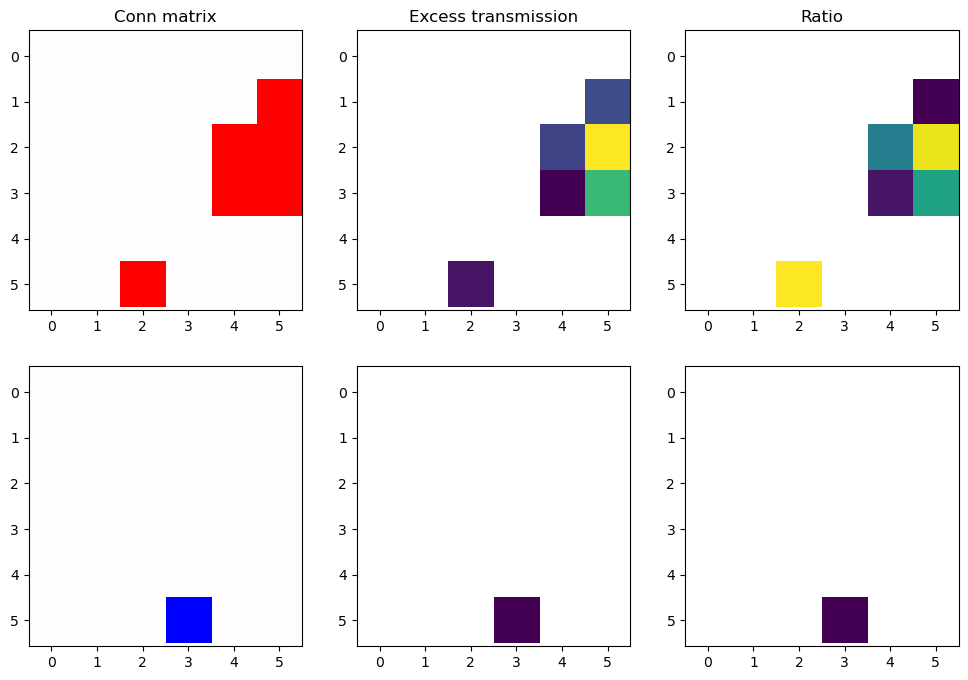

In [10]:
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.imshow(Pcausal_exc, aspect='auto', cmap='bwr', vmin=-1, vmax=1)
plt.title('Conn matrix')
plt.axis('equal')
plt.subplot(232)
plt.imshow(syn_strength_exc, aspect='auto')
plt.title('Excess transmission')
plt.axis('equal')
plt.subplot(233)
plt.imshow(syn_ratio_exc, aspect='auto')
plt.title('Ratio')
plt.axis('equal')
plt.subplot(234)
plt.imshow(Pcausal_inh, aspect='auto', cmap='bwr', vmin=-1, vmax=1)
plt.axis('equal')
plt.subplot(235)
plt.imshow(syn_strength_inh, aspect='auto')
plt.axis('equal')
plt.subplot(236)
plt.imshow(syn_ratio_inh, aspect='auto')
plt.axis('equal')
plt.show()

## New dataset - Phy
https://github.com/dbheadley/mimo_pack/tree/main/test_data/phy

In [11]:
# load spiketimes and cluster id
spkfs = 30000.0
cluid = np.ravel(np.load('spike_clusters.npy', allow_pickle=True))
cluid = cluid+1 # HACK to make it work matching matlab 
spktimes = np.ravel(np.load('spike_times.npy', allow_pickle=True))
spktimes = spktimes/spkfs

# compute N spikes for each unit
cluid_ = np.unique(cluid)
Nspk = np.zeros_like(cluid_, dtype='int')
# Loop through each unique value in Gsub and count occurrences in spkL
for c,cid in enumerate(cluid_):
    Nspk[c] = np.sum(cluid==cid)
nCells = len(Nspk)

# compute CCG
cch, t = CCG(spktimes, cluid, binSize=bin_dur, duration=win_dur, alpha=0.001)

# unique pairs (so we can work in both forward and backward direction)
cc_pairs = np.tril_indices(cch.shape[1], k=-1)
cc_pairs = np.column_stack(cc_pairs)
print(len(cc_pairs))

105


In [12]:
# calculate 1000 times jittered data
cc_null_dist = np.array(run_jittered_ccg(spktimes, cluid, Nspk, jitter_ms=5, binwidth=bin_dur, windowsize=win_dur, num_jitters=shufJitterIter))
cc_null_dist = cc_null_dist.transpose(1, 2, 0) 
# null distribution for alpha = 0.001 and 0.01 for +/- 5 ms jitter
null_ci_alpha = np.percentile(cc_null_dist,q=[alpha,50,100-alpha],axis=2)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 53.56it/s]


In [13]:
# o/p variables 
Pval = np.full([len(t), nCells, nCells], np.nan)
Pred = np.full([len(t), nCells, nCells], np.nan)
Bounds = np.full([cch.shape[0], nCells, nCells, 2], np.nan)
Pcausal_exc = np.zeros([nCells, nCells])
Pcausal_inh = np.zeros([nCells, nCells])
syn_strength_exc = np.full([nCells, nCells], np.nan)
syn_ratio_exc = np.full([nCells, nCells], np.nan)
syn_strength_inh = np.full((nCells, nCells), np.nan)
syn_ratio_inh = np.full((nCells, nCells), np.nan)
sig_con_exc = []
sig_con_inh = []

# post and pre bins to mess with
# some sig. digit shit to deal with
postbins = (t>=min_win_monosyn) & (t<=win_monosyn+bin_dur/2)
prebins = (t<=-min_win_monosyn) & (t>=-win_monosyn-bin_dur/2)
zero_lag_bins = (t>=zero_bins[0]-bin_dur/2) & (t<=zero_bins[1]+bin_dur/2)

# go through each pair 
for refcid in range(nCells):
    for targetcid in range(refcid+1, nCells):
        # ccg for respective connection
        ccg = cch[:, refcid, targetcid]

        # calculate null-distribution using convolution based 
        # on Stark & Abeles; poisson continuity correction
        pvals, pred, qvals = cch_conv(ccg, W, WINTYPE=convType)
        pvals, pred, qvals = np.ravel(pvals), np.ravel(pred), np.ravel(qvals)
        # Store predicted values and pvalues for subsequent plotting
        Pred[:, refcid, targetcid] = pred
        Pval[:, refcid, targetcid] = pvals
        Pred[:, targetcid, refcid] = np.flipud(pred)
        Pval[:, targetcid, refcid] = np.flipud(pvals)
        
        # calculate upper and lower bound with bonferroni correction, given alpha levels
        hiBound, loBound = calculate_bounds(pred, alpha, np.ceil(win_monosyn/bin_dur)*2)
        Bounds[:, refcid, targetcid, 0] = hiBound
        Bounds[:, refcid, targetcid, 1] = loBound
        Bounds[:, targetcid, refcid, 0] = np.flipud(hiBound)
        Bounds[:, targetcid, refcid, 1] = np.flipud(loBound)

        ########## EXCITATORY checks for both sides ref -> target (post), target -> ref (pre)
        sig = ccg > hiBound
        baseline_ccg = ccg - pred
        std_baseline = np.nanstd(baseline_ccg)
        
        # check all condition
        # peak pval < 0.001, peak > 2.5 sd, in [0.8 - 4.8]ms
        # width pval < 0.01, width > 1 sd or 1/2*height of peak
        # no zero lag peaks (common input)
        post_exc_check, pre_exc_check = check_exc_conn(ccg, hiBound, loBound, pred, pvals, postbins, prebins, zero_lag_bins, bin_dur=bin_dur,
                                                       alpha=alpha, alpha2=alpha2, sig_width=sig_width, peaksd=peaksd, widthsd=widthsd)

        # store o/p
        if post_exc_check:
            # sum of values above baseline in postbins
            bccg = baseline_ccg[postbins]
            bccg[bccg<0] = 0
            syn_strength_exc[refcid,targetcid] = np.nansum(bccg)/Nspk[refcid]
            # peak/baseline ratio
            syn_ratio_exc[refcid, targetcid] = np.nanmax(ccg[postbins])/np.nanmean(pred[postbins])
            sig_con_exc.append([refcid, targetcid])
            Pcausal_exc[refcid, targetcid] = 1

        if pre_exc_check:
            # sum of values above baseline in postbins
            bccg = baseline_ccg[prebins]
            bccg[bccg<0] = 0
            syn_strength_exc[targetcid, refcid] = np.nansum(bccg)/Nspk[targetcid]
            # peak/baseline ratio
            syn_ratio_exc[targetcid, refcid] = np.nanmax(ccg[prebins])/np.nanmean(pred[prebins])
            sig_con_exc.append([targetcid, refcid])
            Pcausal_exc[targetcid, refcid] = 1
            
        #print(refcid, targetcid, post_exc_check, pre_exc_check)

        ######### INHIBITORY connections checks again for both directions
        post_inh_check, pre_inh_check = check_inh_conn(ccg, hiBound, loBound, pred, qvals, postbins, prebins, zero_lag_bins, bin_dur=bin_dur, 
                                                       alpha=alpha, alpha2=alpha2, sig_width=sig_width, dipsd=dipsd, widthsd=widthsd)
    
        # remove if excitatory connections detected
        if post_exc_check:
            post_inh_check = False
        if pre_exc_check:
            pre_inh_check = False

        # store o/p
        if post_inh_check:
            # sum of values above baseline in postbins
            bccg = baseline_ccg[postbins]
            bccg[bccg>0] = 0
            syn_strength_inh[refcid,targetcid] = np.abs(np.nansum(bccg))/Nspk[refcid]
            # valley/baseline ratio
            syn_ratio_inh[refcid, targetcid] = np.abs(np.nanmin(ccg[postbins])/np.nanmean(pred[postbins]))
            sig_con_inh.append([refcid, targetcid])
            Pcausal_inh[refcid, targetcid] = -1

        if pre_inh_check:
            # sum of values above baseline in postbins
            bccg = baseline_ccg[prebins]
            bccg[bccg>0] = 0
            syn_strength_inh[targetcid, refcid] = np.abs(np.nansum(bccg)/Nspk[targetcid])
            # valley/baseline ratio
            syn_ratio_inh[targetcid, refcid] = np.abs(np.nanmin(ccg[prebins])/np.nanmean(pred[prebins]))
            sig_con_inh.append([targetcid, refcid])
            Pcausal_inh[targetcid, refcid] = -1

        #print(refcid, targetcid, post_inh_check, pre_inh_check)

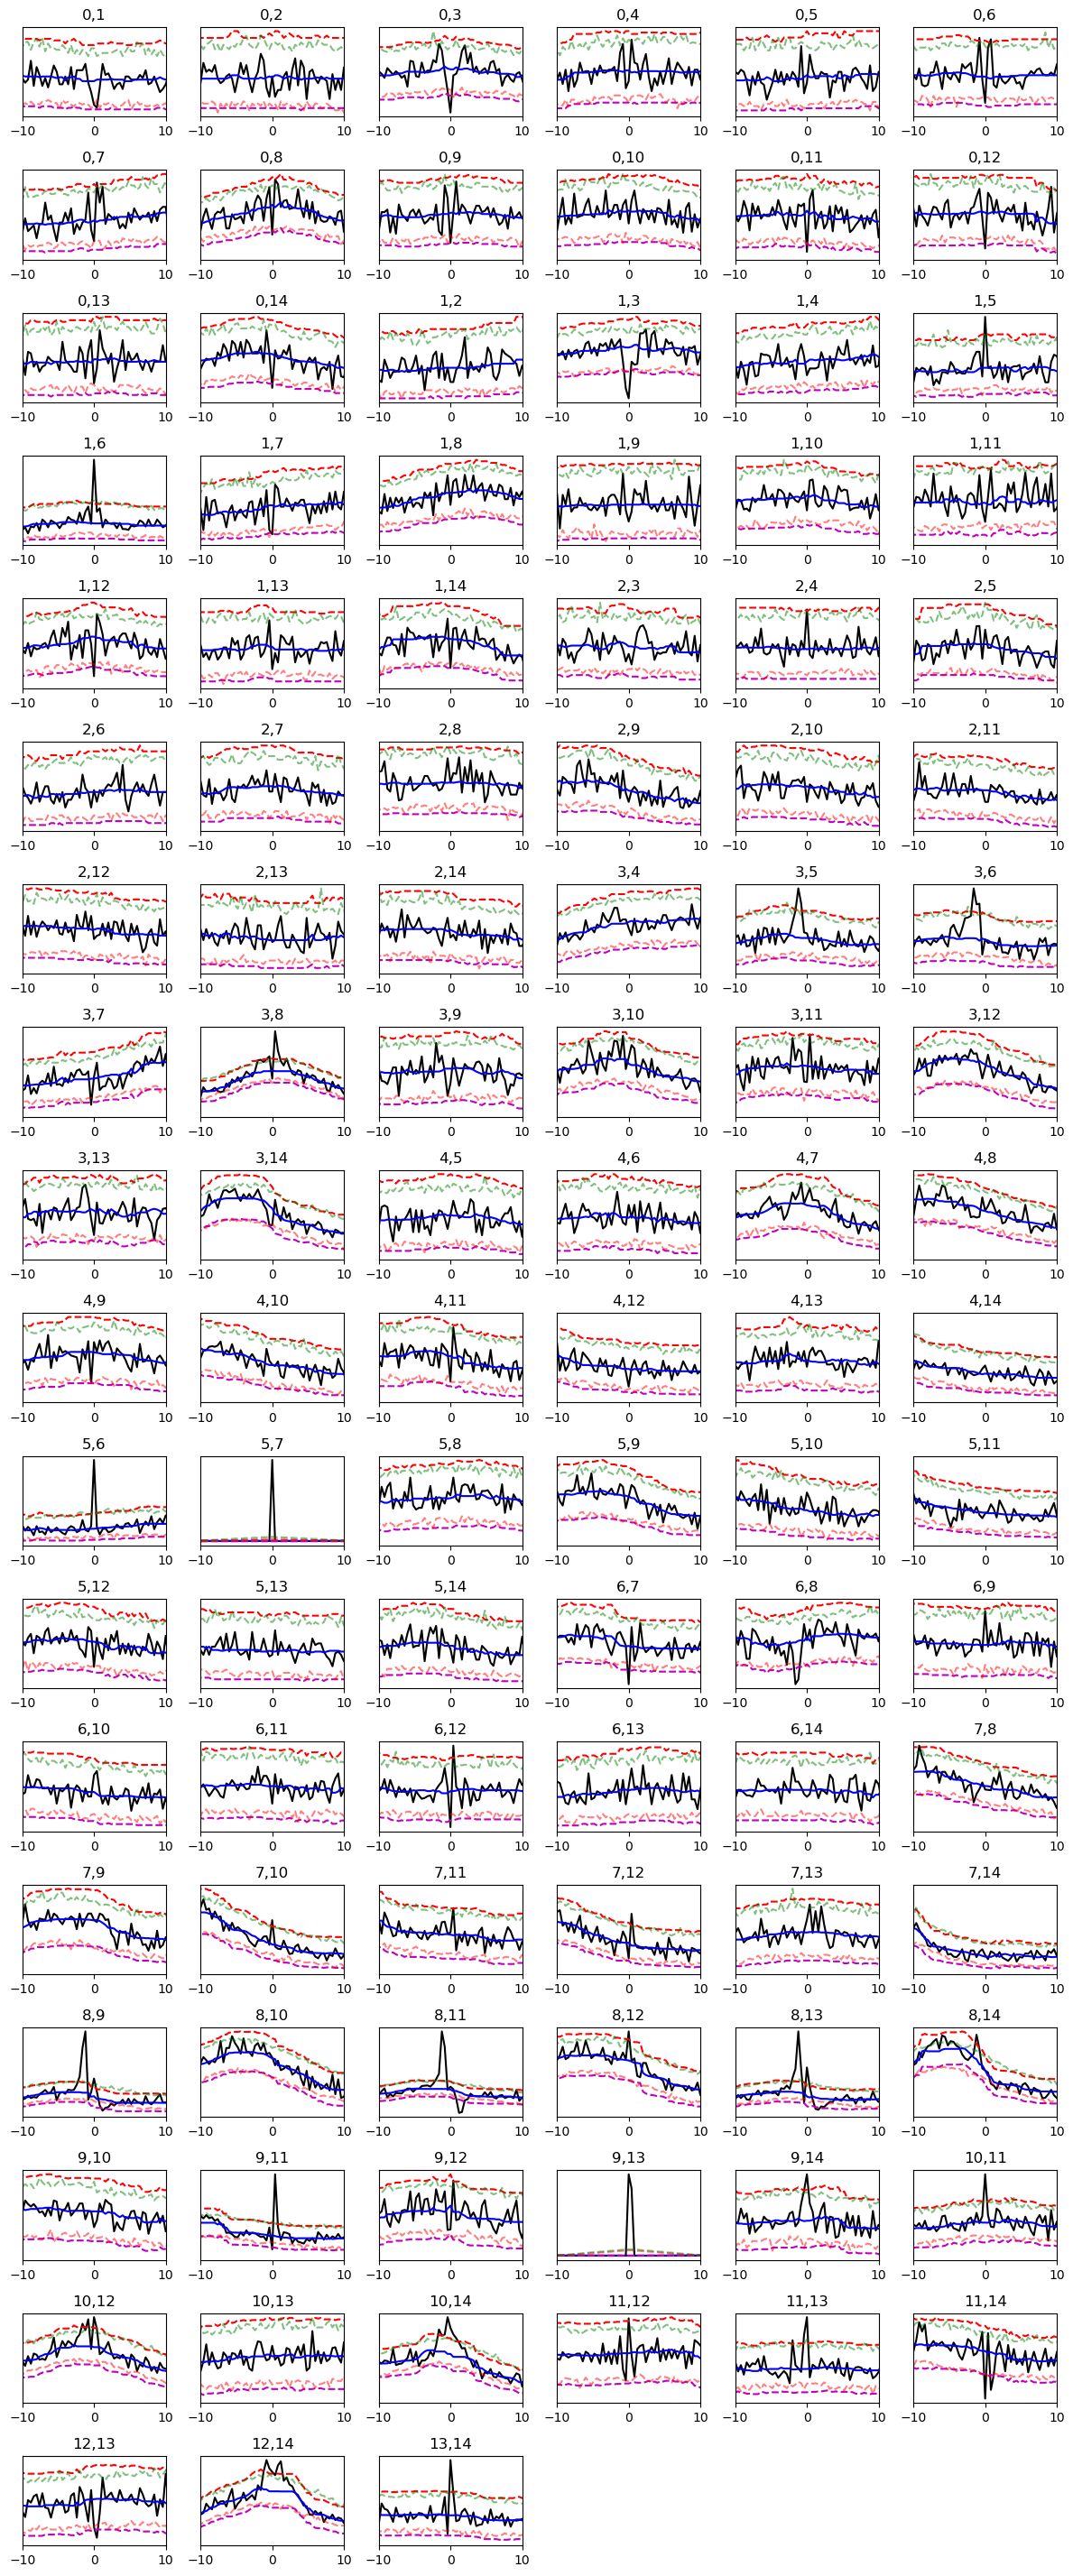

In [14]:
# plot CCG with significance bounds
count = 1 
plt.figure(figsize=(12,30))
for refcid in range(nCells):
    for targetcid in range(refcid+1,nCells):
        plt.subplot(19,6,count)
        plt.plot(t*1000, cch[:,refcid,targetcid], c='k')
        plt.plot(t*1000, Pred[:,refcid,targetcid], c='b')
        plt.plot(t*1000, Bounds[:,refcid,targetcid,0], 'r--')
        plt.plot(t*1000, Bounds[:,refcid,targetcid,1], 'm--')
        plt.plot(t*1000, null_ci_alpha[0,:,targetcid*len(Nspk)+refcid], color='r', ls='--', alpha=0.5)
        plt.plot(t*1000, null_ci_alpha[2,:,targetcid*len(Nspk)+refcid], color='g', ls='--', alpha=0.5)
        plt.xlim([-10,10])
        plt.yticks([])
        plt.title(str(refcid)+','+str(targetcid))
        count = count+1
plt.tight_layout()
plt.show()

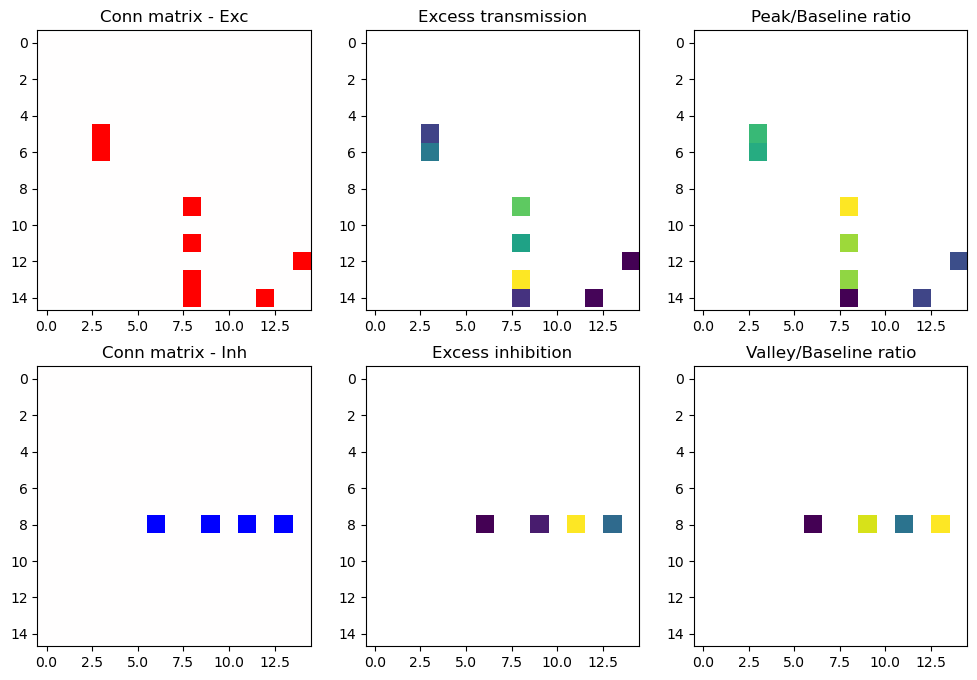

In [15]:
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.imshow(Pcausal_exc, aspect='auto', cmap='bwr', vmin=-1, vmax=1)
plt.title('Conn matrix - Exc')
plt.axis('equal')
plt.subplot(232)
plt.imshow(syn_strength_exc, aspect='auto')
plt.title('Excess transmission')
plt.axis('equal')
plt.subplot(233)
plt.imshow(syn_ratio_exc, aspect='auto')
plt.title('Peak/Baseline ratio')
plt.axis('equal')
plt.subplot(234)
plt.imshow(Pcausal_inh, aspect='auto', cmap='bwr', vmin=-1, vmax=1)
plt.axis('equal')
plt.title('Conn matrix - Inh')
plt.subplot(235)
plt.imshow(syn_strength_inh, aspect='auto')
plt.axis('equal')
plt.title('Excess inhibition')
plt.subplot(236)
plt.imshow(syn_ratio_inh, aspect='auto')
plt.axis('equal')
plt.title('Valley/Baseline ratio')
plt.show()

## New dataset # 2

In [16]:
# preprocess data
spiketimes = np.load('spktimes-testdata.npy', allow_pickle=True)
spktimes = []
cluid = []
Nspk = []
for cid, spkt in enumerate(spiketimes):
    spktimes.extend(spkt)
    cluid.extend([cid+1]*len(spkt))
    Nspk.append(len(spkt))
spktimes = np.array(spktimes)
cluid = np.array(cluid)
Nspk = np.array(Nspk)
nCells = len(Nspk)

# compute CCG
cch, t = CCG(spktimes, cluid, binSize=bin_dur, duration=win_dur, alpha=0.001)

# unique pairs (so we can work in both forward and backward direction)
cc_pairs = np.tril_indices(cch.shape[1], k=-1)
cc_pairs = np.column_stack(cc_pairs)
print(len(cc_pairs))

16836


In [17]:
# o/p variables 
Pval = np.full([len(t), nCells, nCells], np.nan)
Pred = np.full([len(t), nCells, nCells], np.nan)
Bounds = np.full([cch.shape[0], nCells, nCells, 2], np.nan)
Pcausal_exc = np.zeros([nCells, nCells])
Pcausal_inh = np.zeros([nCells, nCells])
syn_strength_exc = np.full([nCells, nCells], np.nan)
syn_ratio_exc = np.full([nCells, nCells], np.nan)
syn_strength_inh = np.full((nCells, nCells), np.nan)
syn_ratio_inh = np.full((nCells, nCells), np.nan)
sig_con_exc = []
sig_con_inh = []

# post and pre bins to mess with
# some sig. digit shit to deal with
postbins = (t>=min_win_monosyn) & (t<=win_monosyn+bin_dur/2)
prebins = (t<=-min_win_monosyn) & (t>=-win_monosyn-bin_dur/2)
zero_lag_bins = (t>=zero_bins[0]-bin_dur/2) & (t<=zero_bins[1]+bin_dur/2)

# go through each pair 
for refcid in tqdm(range(nCells)):
    for targetcid in range(refcid+1, nCells):
        # ccg for respective connection
        ccg = cch[:, refcid, targetcid]

        # firing rate threshold
        if np.nansum([sum(ccg[prebins]), sum(ccg[zero_lag_bins]), sum(ccg[postbins])])>spkTh:
            # calculate null-distribution using convolution based 
            # on Stark & Abeles; poisson continuity correction
            pvals, pred, qvals = cch_conv(ccg, W, WINTYPE=convType)
            pvals, pred, qvals = np.ravel(pvals), np.ravel(pred), np.ravel(qvals)
            # Store predicted values and pvalues for subsequent plotting
            Pred[:, refcid, targetcid] = pred
            Pval[:, refcid, targetcid] = pvals
            Pred[:, targetcid, refcid] = np.flipud(pred)
            Pval[:, targetcid, refcid] = np.flipud(pvals)
            
            # calculate upper and lower bound with bonferroni correction, given alpha levels
            hiBound, loBound = calculate_bounds(pred, alpha, np.ceil(win_monosyn/bin_dur)*2)
            Bounds[:, refcid, targetcid, 0] = hiBound
            Bounds[:, refcid, targetcid, 1] = loBound
            Bounds[:, targetcid, refcid, 0] = np.flipud(hiBound)
            Bounds[:, targetcid, refcid, 1] = np.flipud(loBound)
    
            # get baseline ccg and std
            baseline_ccg = ccg - pred
            std_baseline = np.nanstd(baseline_ccg)
    
            ########## EXCITATORY checks for both sides ref -> target (post), target -> ref (pre)
            sig = ccg > hiBound
            
            # check all condition
            # peak pval < 0.001, peak > 2.5 sd, in [0.8 - 4.8]ms
            # width pval < 0.01, width > 1 sd or 1/2*height of peak
            # no zero lag peaks (common input)
            post_exc_check, pre_exc_check = check_exc_conn(ccg, hiBound, loBound, pred, pvals, postbins, prebins, zero_lag_bins, bin_dur=bin_dur,
                                                           alpha=alpha, alpha2=alpha2, sig_width=sig_width, peaksd=peaksd, widthsd=widthsd)
            
            # store o/p
            if post_exc_check:
                # sum of values above baseline in postbins
                bccg = baseline_ccg[postbins]
                bccg[bccg<0] = 0
                syn_strength_exc[refcid,targetcid] = np.nansum(bccg)/Nspk[refcid]
                # peak/baseline ratio
                syn_ratio_exc[refcid, targetcid] = np.nanmax(ccg[postbins])/np.nanmean(pred[postbins])
                sig_con_exc.append([refcid, targetcid])
                Pcausal_exc[refcid, targetcid] = 1
    
            if pre_exc_check:
                # sum of values above baseline in postbins
                bccg = baseline_ccg[prebins]
                bccg[bccg<0] = 0
                syn_strength_exc[targetcid, refcid] = np.nansum(bccg)/Nspk[targetcid]
                # peak/baseline ratio
                syn_ratio_exc[targetcid, refcid] = np.nanmax(ccg[prebins])/np.nanmean(pred[prebins])
                sig_con_exc.append([targetcid, refcid])
                Pcausal_exc[targetcid, refcid] = 1
    
            #print(refcid, targetcid, post_exc_check, pre_exc_check)
    
            ######### INHIBITORY connections checks again for both directions
            post_inh_check, pre_inh_check = check_inh_conn(ccg, hiBound, loBound, pred, qvals, postbins, prebins, zero_lag_bins, bin_dur=bin_dur, 
                                                           alpha=alpha, alpha2=alpha2, sig_width=sig_width_inh, dipsd=dipsd, widthsd=widthsd)
            # remove if excitatory connections detected
            if post_exc_check:
                post_inh_check = False
            if pre_exc_check:
                pre_inh_check = False
    
            # store o/p
            if post_inh_check:
                # sum of values above baseline in postbins
                bccg = baseline_ccg[postbins]
                bccg[bccg>0] = 0
                syn_strength_inh[refcid,targetcid] = np.abs(np.nansum(bccg))/Nspk[refcid]
                # valley/baseline ratio
                syn_ratio_inh[refcid, targetcid] = np.abs(np.nanmin(ccg[postbins])/np.nanmean(pred[postbins]))
                sig_con_inh.append([refcid, targetcid])
                Pcausal_inh[refcid, targetcid] = -1
    
            if pre_inh_check:
                # sum of values above baseline in postbins
                bccg = baseline_ccg[prebins]
                bccg[bccg>0] = 0
                syn_strength_inh[targetcid, refcid] = np.abs(np.nansum(bccg)/Nspk[targetcid])
                # valley/baseline ratio
                syn_ratio_inh[targetcid, refcid] = np.abs(np.nanmin(ccg[prebins])/np.nanmean(pred[prebins]))
                sig_con_inh.append([targetcid, refcid])
                Pcausal_inh[targetcid, refcid] = -1
        #print(refcid, targetcid, post_inh_check, pre_inh_check)
sig_con_exc = np.array(sig_con_exc)
sig_con_inh = np.array(sig_con_inh)

100%|████████████████████████████████████████████████████████████████████████████████| 184/184 [01:12<00:00,  2.54it/s]


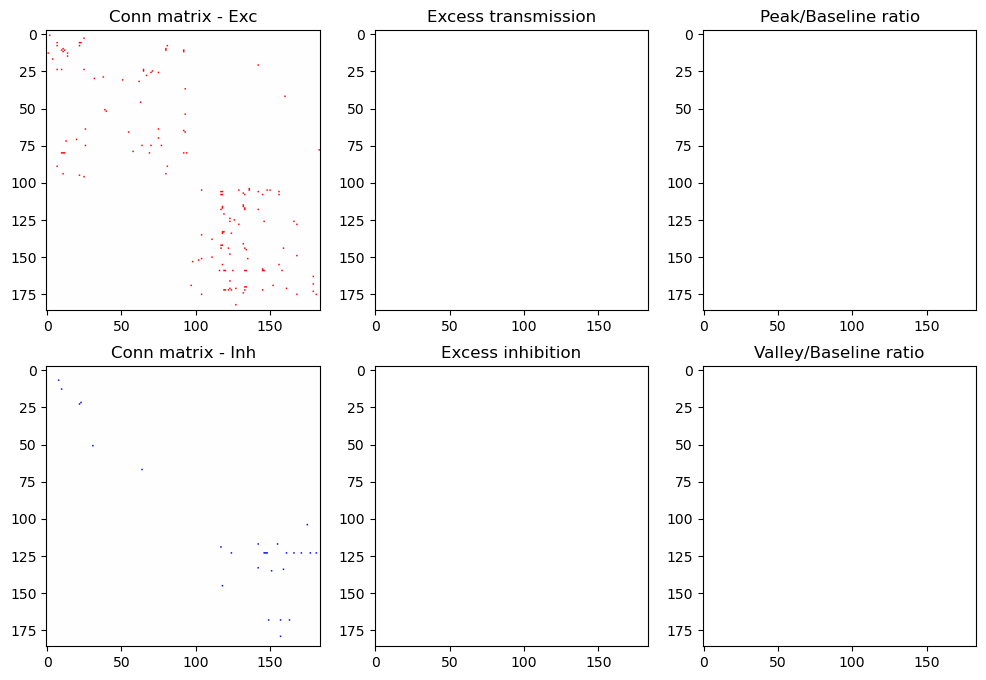

In [18]:
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.imshow(Pcausal_exc, aspect='auto', cmap='bwr', vmin=-1, vmax=1)
plt.title('Conn matrix - Exc')
plt.axis('equal')
plt.subplot(232)
plt.imshow(syn_strength_exc, aspect='auto')
plt.title('Excess transmission')
plt.axis('equal')
plt.subplot(233)
plt.imshow(syn_ratio_exc, aspect='auto')
plt.title('Peak/Baseline ratio')
plt.axis('equal')
plt.subplot(234)
plt.imshow(Pcausal_inh, aspect='auto', cmap='bwr', vmin=-1, vmax=1)
plt.axis('equal')
plt.title('Conn matrix - Inh')
plt.subplot(235)
plt.imshow(syn_strength_inh, aspect='auto')
plt.axis('equal')
plt.title('Excess inhibition')
plt.subplot(236)
plt.imshow(syn_ratio_inh, aspect='auto')
plt.axis('equal')
plt.title('Valley/Baseline ratio')
plt.show()

the other subplots are not empty, they just need to be log-scaled

In [19]:
len(sig_con_exc), (len(sig_con_exc)/len(cc_pairs)), len(sig_con_inh), (len(sig_con_inh)/len(cc_pairs))

(153, 0.009087669280114041, 27, 0.0016037063435495368)

In [20]:
err

NameError: name 'err' is not defined

#### load CCG processed data
dat = np.load(r'T:\SWIL-Rajat\ThetaMod-SWIL\CCGprocessed\SWIL12-ccg.npz')
conn_mat = dat['conn_mat']
conn_mat[conn_mat>0] = 1
conn_mat[conn_mat<0] = -1
print(conn_mat.shape)

#indices = np.argwhere(Pcausal_exc==1)
row, col = np.where((conn_mat!=-1) & (Pcausal_inh==-1))
for r,c in zip(row,col):
    plt.figure(figsize=(3,2))
    plt.plot(t*1000, cch[:, r, c], 'k')
    plt.plot(t*1000, Bounds[:,r,c, 0], 'r--')
    plt.plot(t*1000, Bounds[:,r,c, 1], 'm--')
    plt.title(str(r)+' , '+str(c))
    plt.xlim([-10,10])
    plt.show()